There is an issue with the resulting time series that have been used in the model so far. In short: people appear to spend more time in other provinces during the weekends as compared to during weekdays. This is not realistic and does not correspond to the raw data. Let's plot some raw data first.

# Show the issue by showing the raw data

In [1]:
# takes approx 110 seconds

import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data.mobility import *
from covid19model.data.model_parameters import *

In [ ]:
data_location = "../../data/raw/mobility/proximus/postalcodes/"
t0 = pd.Timestamp(2020, 1, 1)
PC_from='1000'
PC_to='1000'

days=[]
est_staytimes=[]
for day in range(365*2):
    print(f'Loading day {day}', end='\r')
    t = t0 + pd.Timedelta(days=day)
    days.append(t)
    try:
        unprocessed_data = load_datafile_proximus(t.strftime('%Y%m%d'), data_location)
        unprocessed_data = unprocessed_data.loc[unprocessed_data['mllp_postalcode']==PC_from]
        unprocessed_data = unprocessed_data.loc[unprocessed_data['postalcode']==PC_to]
        est_staytime = unprocessed_data.est_staytime.values[0]
    except:
        est_staytime = np.nan
    est_staytimes.append(est_staytime)

In [ ]:
fig,ax = plt.subplots(figsize=(15, 3))
ax.plot(days, est_staytimes, linewidth=1)
ax.grid(False)
ax.legend([f'{PC_from} to {PC_to}'], loc='upper left')

# Clearly time spent in other postal codes goes DOWN in the weekends, not up.
# Interestingly, time spent in the home postal code ALSO goes down in the weekends

# Do some data cleaning and see whether the problem exists after

In [ ]:
# We start off doing the same thing, but add some data cleaning steps
# Takes about ten minutes

data_location = "../../data/raw/mobility/proximus/postalcodes/"
t0 = pd.Timestamp(2020, 1, 1)
PC_from='1000'
PC_to='1020'

days=[]
est_staytimes=[]
for day in range(365*2):
    print(f'Loading day {day}', end='\r')
    t = t0 + pd.Timedelta(days=day)
    days.append(t)
    try:
        unprocessed_data = load_datafile_proximus(t.strftime('%Y%m%d'), data_location)
        
        # Pivot unprocessed data into correct origin-destination mobility matrix
        mmprox_staytime = load_mmprox(unprocessed_data, values='est_staytime')
        # Add missing postal codes (with value 0)
        mmprox_staytime = fill_missing_pc(mmprox_staytime)
        # Add missing seconds to 'stay at home' patch and subtract time spent asleep
        missing_seconds = missing_seconds_per_pc(unprocessed_data)
        mmprox_staytime = complete_home_staytime(mmprox_staytime, missing_seconds)
        # Change GDPR-protected -1 values to estimated staytime value
        est_hidden_staytime = est_hidden_staytime_per_pc(unprocessed_data)
        mmprox_staytime = GDPR_staytime(mmprox_staytime, est_hidden_staytime)
        # Add the value to the array
        est_staytime = mmprox_staytime.loc[PC_from,PC_to]
    except:
        est_staytime = np.nan
    est_staytimes.append(est_staytime)

In [ ]:
fig,ax = plt.subplots(figsize=(15, 3))

ax.plot(days, est_staytimes, linewidth=1)
ax.grid(False)
ax.legend([f'{PC_from} to {PC_to}'], loc='upper left')

# For postal codes 1000 and 1020 there clearly is no difference here
# But perhaps the problem arises for different combinations of postal codes

# Aggregating per province

The next step is where things should clearly start going wrong, because so far everything still looks good.

In [ ]:
# We start off doing the same thing, but add some data cleaning steps

data_location = "../../data/raw/mobility/proximus/postalcodes/"
t0 = pd.Timestamp(2020, 1, 1)
PC_from='10000'
PC_to='21000'

agg='prov'

days=[]
est_staytimes=[]
for day in range(45):
    print(f'Loading day {day}', end='\r')
    t = t0 + pd.Timedelta(days=day)
    days.append(t)
    try:
        unprocessed_data = load_datafile_proximus(t.strftime('%Y%m%d'), data_location)
        # Pivot unprocessed data into correct origin-destination mobility matrix
        mmprox_staytime = load_mmprox(unprocessed_data, values='est_staytime')
        # Add missing postal codes (with value 0)
        mmprox_staytime = fill_missing_pc(mmprox_staytime)
        # Add missing seconds to 'stay at home' patch and subtract time spent asleep
        missing_seconds = missing_seconds_per_pc(unprocessed_data)
        mmprox_staytime = complete_home_staytime(mmprox_staytime, missing_seconds)
        # Change GDPR-protected -1 values to estimated staytime value
        est_hidden_staytime = est_hidden_staytime_per_pc(unprocessed_data)
        mmprox_staytime = GDPR_staytime(mmprox_staytime, est_hidden_staytime)
        
        # Aggregate staytime values at the level of agg
        mmprox_staytime_agg = mm_aggregate(mmprox_staytime, agg=agg)
        # Add the value to the array
        est_staytime = mmprox_staytime_agg.loc[PC_from,PC_to]
    except:
        est_staytime = np.nan
    est_staytimes.append(est_staytime)

In [ ]:
fig,ax = plt.subplots(figsize=(15, 3))

ax.plot(days, est_staytimes, linewidth=1)
ax.grid(False)
ax.legend([f'{PC_from} to {PC_to}'], loc='upper left')

# For postal codes 1000 and 1020 there clearly is no difference here
# But perhaps the problem arises for different combinations of postal codes

# Show problem with GDPR -1 values

## Problem arises from postalcode data

In [32]:
t = pd.Timestamp(2020, 6, 1)
data_location = "../../data/raw/mobility/proximus/postalcodes/"

# Load all data
unprocessed_data = load_datafile_proximus(t.strftime('%Y%m%d'), data_location)

# Make array of all unique postalcodes in the data
pc_array = unprocessed_data.mllp_postalcode.unique()

# Loop over all postal codes and fill in GDPR protected data with an estimate
# It is important to do this in the first step: this will compensate automatically at the provincial level
for pc in pc_array:
    # Define two masks
    mask_mllp = unprocessed_data['mllp_postalcode']==pc
    mask_GDPR = unprocessed_data['est_staytime']==-1
    
    # Number of GDPR protected data points for this particular postalcode
    GDPR_protected_size = unprocessed_data[mask_mllp & mask_GDPR].est_staytime.size

    # Calculate the reported total est_staytime versus the calculated (summed) total est_staytime
    total_est_staytime = unprocessed_data.loc[mask_mllp, 'total_est_staytime'].values[0]
    summed_est_staytime = unprocessed_data[mask_mllp][['est_staytime']].sum(axis=0).values[0]

    # Calculate number of hidden seconds and make up for summing the -1 values
    hidden_seconds = total_est_staytime - summed_est_staytime + GDPR_protected_size
    hidden_seconds_per_pc = hidden_seconds / GDPR_protected_size

    # Distribute all hidden seconds evenly to all GDPR-protected postalcodes
    unprocessed_data.loc[mask_mllp & mask_GDPR,'est_staytime'] = hidden_seconds_per_pc
    
    print(f'processed postalcode {pc} with hidden seconds per pc: {int(hidden_seconds_per_pc)}.          ', end='\r')

In [134]:
# Next, merge all postalcodes together in provinces

# pc-to-pc matrix
mmprox = load_mmprox(unprocessed_data, values='est_staytime')

# Add postalcodes that Proximus has missed
mmprox = fill_missing_pc(mmprox)

# Aggregate at the level of provinces
mmprox = mm_aggregate(mmprox, agg='prov')

# Note that this still contains 'Foreigner' and 'ABROAD'
mmprox

postalcode,10000,20001,20002,21000,30000,40000,50000,60000,70000,80000,90000,ABROAD
mllp_postalcode,,,,,,,,,,,,
10000,3.906495e+10,4.493037e+08,4.190644e+07,6.413824e+07,3.661174e+08,3.392708e+08,5.018604e+07,1.220771e+08,2.133165e+08,9.771926e+07,7.398144e+07,1.385098e+08
20001,3.712529e+08,2.889109e+10,2.403691e+08,5.067834e+08,3.790278e+08,3.770828e+08,1.889737e+08,1.332223e+08,1.903929e+08,9.148697e+07,1.244776e+08,3.629093e+07
20002,2.565704e+07,2.481139e+08,1.330587e+10,1.310471e+08,9.135406e+07,3.213408e+07,2.448148e+08,1.136134e+08,1.339593e+07,6.694949e+07,1.525367e+08,1.780257e+07
21000,1.022020e+08,7.281516e+08,2.402833e+08,2.339884e+10,3.367529e+08,1.170958e+08,2.300267e+08,1.485366e+08,5.198286e+07,9.843298e+07,1.300218e+08,1.153185e+08
30000,9.534149e+07,1.000984e+08,1.548559e+07,3.692239e+07,2.866964e+10,4.492375e+08,2.085987e+08,3.496059e+07,2.995625e+07,5.051796e+07,4.917710e+07,4.966611e+07
40000,3.064310e+08,3.629416e+08,3.570593e+07,6.672228e+07,8.116431e+08,3.620766e+10,1.832090e+08,5.547699e+07,5.781699e+07,8.165787e+07,7.224522e+07,8.670362e+07
50000,2.472798e+07,1.607748e+08,2.087199e+08,1.156284e+08,3.103038e+08,1.224214e+08,3.561622e+10,1.135065e+08,1.345874e+07,1.077141e+08,3.608523e+08,9.015047e+07
60000,2.374462e+07,6.801651e+07,7.032700e+07,6.116534e+07,6.843859e+07,2.132593e+07,8.940972e+07,2.821423e+10,1.243075e+08,1.843813e+08,1.742025e+08,1.048086e+08
70000,1.628596e+08,1.914275e+08,1.053138e+07,2.183709e+07,7.674356e+07,4.421159e+07,1.224019e+07,1.714137e+08,1.979806e+10,3.010137e+07,2.062289e+07,9.700946e+07


In [135]:
# For every province we know the population, so we also know the amount of 'missing seconds',
# i.e. seconds that weren't registered. These unregistered seconds are added the home province

# Load initN at province level
initN, _, _, _ = get_COVID19_SEIQRD_parameters(spatial='prov')

# Loop over province NIS values and add unregistered waking-life seconds
for NIS in initN.index:
    NIS_pop = initN.sum(axis=1).loc[NIS]
    available_seconds_NIS = NIS_pop * 60 * 60 * 16 # 8 hours asleep
    registered_seconds_NIS = mmprox.loc[str(NIS)].sum()
    unregistered_seconds_NIS = available_seconds_NIS - registered_seconds_NIS
    print(f'{NIS}: unregistered waking-life seconds: {int(unregistered_seconds_NIS)} ({round(unregistered_seconds_NIS/available_seconds_NIS*100)} percent).')
    mmprox.loc[str(NIS), str(NIS)] += unregistered_seconds_NIS

10000: unregistered waking-life seconds: 66674974223 (62 percent).
20001: unregistered waking-life seconds: 35046106860 (53 percent).
20002: unregistered waking-life seconds: 8943407419 (38 percent).
21000: unregistered waking-life seconds: 44473845312 (63 percent).
30000: unregistered waking-life seconds: 39384833033 (57 percent).
40000: unregistered waking-life seconds: 49526473868 (56 percent).
50000: unregistered waking-life seconds: 40333509865 (52 percent).
60000: unregistered waking-life seconds: 34720121444 (54 percent).
70000: unregistered waking-life seconds: 29899457650 (59 percent).
80000: unregistered waking-life seconds: 8164150301 (49 percent).
90000: unregistered waking-life seconds: 12649589148 (44 percent).


In [150]:
# Now we only have to deal with the 'ABROAD' category, which might be a pain in the ass ...
# The final step is to just normalise everything

mmprox_BE = mmprox.drop(index=['Foreigner'], columns=['ABROAD'])
mmprox_BE.div(mmprox_BE.sum(axis=1),axis=0)

# Clearly the vast majority of time is spent in the home province, which obiously makes sense.

postalcode,10000,20001,20002,21000,30000,40000,50000,60000,70000,80000,90000
mllp_postalcode,,,,,,,,,,,
10000,0.983097,0.004177,0.000390,0.000596,0.003404,0.003154,0.000467,0.001135,0.001983,0.000909,0.000688
20001,0.005579,0.960880,0.003612,0.007616,0.005696,0.005667,0.002840,0.002002,0.002861,0.001375,0.001871
20002,0.001098,0.010617,0.952089,0.005608,0.003909,0.001375,0.010476,0.004862,0.000573,0.002865,0.006527
21000,0.001459,0.010394,0.003430,0.968832,0.004807,0.001671,0.003283,0.002120,0.000742,0.001405,0.001856
30000,0.001379,0.001448,0.000224,0.000534,0.984516,0.006499,0.003018,0.000506,0.000433,0.000731,0.000711
40000,0.003491,0.004135,0.000407,0.000760,0.009248,0.976827,0.002087,0.000632,0.000659,0.000930,0.000823
50000,0.000319,0.002075,0.002694,0.001492,0.004005,0.001580,0.980150,0.001465,0.000174,0.001390,0.004657
60000,0.000372,0.001066,0.001102,0.000958,0.001072,0.000334,0.001401,0.986128,0.001948,0.002889,0.002730
70000,0.003229,0.003795,0.000209,0.000433,0.001521,0.000877,0.000243,0.003398,0.985290,0.000597,0.000409


Concluding, the two main issues are:
1. We do not really know how to handle the GDPR protection, and just estimate it based on the number of missing seconds in the raw data.
2. We do not really know how to handle traffic abroad. All the time that people from province `g` spend abroad is now just ignored, and by normalising in the end, it is _implicitly_ assumed that all these people that actually travelled abroad are evenly spread over the 10+1 provinces. We could also choose to (i) count them as people that stay at home, or (ii) spread them over all provinces weighted by the population in those provinces.

In [3]:
# Add all these methods together starting from raw data
def complete_data_clean_new(unprocessed_data, initN):    
    # Make array of all unique postalcodes in the data
    pc_array = unprocessed_data.mllp_postalcode.unique()
    
    print('Found postalcodes array')

    # Loop over all postal codes and fill in GDPR protected data with an estimate
    # It is important to do this in the first step: this will compensate automatically at the provincial level
    for pc in pc_array:
        # Define two masks
        mask_mllp = unprocessed_data['mllp_postalcode']==pc
        mask_GDPR = unprocessed_data['est_staytime']==-1

        # Number of GDPR protected data points for this particular postalcode
        GDPR_protected_size = unprocessed_data[mask_mllp & mask_GDPR].est_staytime.size

        # Calculate the reported total est_staytime versus the calculated (summed) total est_staytime
        total_est_staytime = unprocessed_data.loc[mask_mllp, 'total_est_staytime'].values[0]
        summed_est_staytime = unprocessed_data[mask_mllp][['est_staytime']].sum(axis=0).values[0]

        # Calculate number of hidden seconds and make up for summing the -1 values
        hidden_seconds = total_est_staytime - summed_est_staytime + GDPR_protected_size
        hidden_seconds_per_pc = hidden_seconds / GDPR_protected_size

        # Distribute all hidden seconds evenly to all GDPR-protected postalcodes
        unprocessed_data.loc[mask_mllp & mask_GDPR,'est_staytime'] = hidden_seconds_per_pc
        
    # Next, merge all postalcodes together in provinces
    # Note that this still contains 'Foreigner' and 'ABROAD'
    
    print('Added GDPR-protected seconds')

    # pc-to-pc matrix
    mmprox = load_mmprox(unprocessed_data, values='est_staytime')
    
    print('Made pc-to-pc matrix')

    # Add postalcodes that Proximus has missed
    mmprox = fill_missing_pc(mmprox)
    
    print('Added missing postal codes')

    # Aggregate at the level of provinces
    mmprox = mm_aggregate(mmprox, agg='prov')
    
    print('Aggregated postal codes at provincial level')

    # Loop over province NIS values and add unregistered waking-life seconds
    for NIS in initN.index:
        NIS_pop = initN.sum(axis=1).loc[NIS]
        available_seconds_NIS = NIS_pop * 60 * 60 * 16 # 8 hours asleep
        registered_seconds_NIS = mmprox.loc[str(NIS)].sum()
        unregistered_seconds_NIS = available_seconds_NIS - registered_seconds_NIS
        mmprox.loc[str(NIS), str(NIS)] += unregistered_seconds_NIS
        
    print('Add unregistered waking-life seconds to home province')
        
    # Now we only have to deal with the 'ABROAD' category, which might be a pain in the ass ...
    # Also, it is not always present

    try:
        mmprox = mmprox.drop(index=['Foreigner'])
    except:
        print("'Foreigner' index not found.")
        pass
    try:
        mmprox = mmprox.drop(columns=['ABROAD'])
    except:
        print("'ABROAD' column not found.")
        pass
        
    mmprox_clean = mmprox.div(mmprox.sum(axis=1),axis=0)

    # Clearly the vast majority of time is spent in the home province, which obiously makes sense.
    
    print('Complete data cleaning')
    
    return mmprox_clean

In [13]:
t0 = pd.Timestamp(2020, 2, 10)
data_location = "../../data/raw/mobility/proximus/postalcodes/"
initN, _, _, _ = get_COVID19_SEIQRD_parameters(spatial='prov')

unprocessed_data = load_datafile_proximus(t0.strftime('%Y%m%d'), data_location)

pc_array = unprocessed_data.mllp_postalcode.unique()

# for pc in pc_array:
#     # Define two masks
#     mask_mllp = unprocessed_data['mllp_postalcode']==pc
#     mask_GDPR = unprocessed_data['est_staytime']==-1

#     # Number of GDPR protected data points for this particular postalcode
#     GDPR_protected_size = unprocessed_data[mask_mllp & mask_GDPR].est_staytime.size

#     # Calculate the reported total est_staytime versus the calculated (summed) total est_staytime
#     total_est_staytime = unprocessed_data.loc[mask_mllp, 'total_est_staytime'].values[0]
#     summed_est_staytime = unprocessed_data[mask_mllp][['est_staytime']].sum(axis=0).values[0]

#     # print('found total and summed staytimes', end='\r')

#     # Calculate number of hidden seconds and make up for summing the -1 values
#     hidden_seconds = total_est_staytime - summed_est_staytime + GDPR_protected_size
#     hidden_seconds_per_pc = hidden_seconds / GDPR_protected_size

#     # Distribute all hidden seconds evenly to all GDPR-protected postalcodes
#     unprocessed_data.loc[mask_mllp & mask_GDPR,'est_staytime'] = hidden_seconds_per_pc
    
#     print(f'Finished working on postalcode {pc}.            ', end='\r')

# pc-to-pc matrix
mmprox = load_mmprox(unprocessed_data, values='est_staytime')

# Add postalcodes that Proximus has missed
mmprox = fill_missing_pc(mmprox)

# Aggregate at the level of provinces
mmprox = mm_aggregate(mmprox, agg='prov')

# Loop over province NIS values and add unregistered waking-life seconds
for NIS in initN.index:
    NIS_pop = initN.sum(axis=1).loc[NIS]
    available_seconds_NIS = NIS_pop * 60 * 60 * 16 # 8 hours asleep
    registered_seconds_NIS = mmprox.loc[str(NIS)].sum()
    unregistered_seconds_NIS = available_seconds_NIS - registered_seconds_NIS
    mmprox.loc[str(NIS), str(NIS)] += unregistered_seconds_NIS

mmprox = mmprox.drop(index=['Foreigner'])
mmprox = mmprox.drop(columns=['ABROAD'])
    
mmprox

postalcode,10000,20001,20002,21000,30000,40000,50000,60000,70000,80000,90000
mllp_postalcode,,,,,,,,,,,
10000,1.064146e+11,3.227754e+08,-1.153000e+03,1.468677e+08,8.350870e+05,1.689233e+08,-2.180000e+03,-2.154000e+03,8.259609e+07,-9.440000e+02,-1.147000e+03
20001,2.707465e+08,6.385258e+10,1.446773e+08,1.593686e+09,-3.081000e+03,2.046690e+08,2.673973e+07,5.542643e+06,1.084817e+08,-1.168000e+03,-1.841000e+03
20002,-1.091000e+03,2.240531e+08,2.219271e+10,5.833003e+08,-6.800000e+02,-8.500000e+02,9.695524e+07,2.190516e+07,-5.700000e+02,-7.360000e+02,9.232263e+07
21000,3.018523e+07,6.513669e+08,1.922387e+08,6.875032e+10,1.267690e+06,1.610413e+07,1.448882e+07,6.527899e+06,-6.590000e+02,2.056650e+05,1.363853e+07
30000,2.397656e+06,5.797870e+06,-7.460000e+02,3.108717e+07,6.839621e+10,3.497557e+08,1.022680e+08,-1.238000e+03,-1.092000e+03,-6.790000e+02,-9.280000e+02
40000,3.122879e+08,2.714192e+08,-1.237000e+03,3.147659e+08,2.398592e+08,8.628333e+10,4.769429e+07,-1.710000e+03,-1.606000e+03,-9.560000e+02,-1.176000e+03
50000,-2.237000e+03,5.404058e+07,2.016815e+08,2.073805e+08,1.230178e+08,7.049750e+07,7.643281e+10,-3.284000e+03,-1.045000e+03,-1.431000e+03,1.652576e+08
60000,-1.986000e+03,1.197684e+07,2.388676e+07,4.838529e+07,-1.020000e+03,-1.198000e+03,9.300760e+05,6.334409e+10,4.245635e+07,4.035965e+07,8.266216e+07
70000,1.099302e+08,1.795345e+08,-6.230000e+02,1.845057e+07,-1.202000e+03,7.530720e+05,-1.104000e+03,5.600216e+07,4.989109e+10,-6.040000e+02,-7.000000e+02


In [7]:
t0 = pd.Timestamp(2020, 2, 10)
data_location = "../../data/raw/mobility/proximus/postalcodes/"
unprocessed_data = load_datafile_proximus(t0.strftime('%Y%m%d'), data_location)

unprocessed_data

,mllp_postalcode,postalcode,imsisinpostalcode,habitants,nrofimsi,visitors,est_staytime,total_est_staytime,est_staytime_perc
0,1000,1000,16611.0,52832.0,14913.0,50952.0,6.061679e+08,9.054094e+08,66.949600
1,1000,1020,16611.0,52832.0,388.0,1326.0,4.579928e+06,9.054094e+08,0.505841
2,1000,1030,16611.0,52832.0,775.0,2648.0,9.032152e+06,9.054094e+08,0.997577
3,1000,1040,16611.0,52832.0,1984.0,6779.0,3.217718e+07,9.054094e+08,3.553881
4,1000,1050,16611.0,52832.0,1795.0,6133.0,2.295982e+07,9.054094e+08,2.535849
...,...,...,...,...,...,...,...,...,...
326292,Foreigner,9988,518262.0,NaN,177.0,492.0,2.382758e+06,1.910879e+10,0.012469
326293,Foreigner,9990,518262.0,NaN,697.0,1815.0,8.596748e+06,1.910879e+10,0.044988
326294,Foreigner,9991,518262.0,NaN,266.0,667.0,3.261948e+06,1.910879e+10,0.017070
326295,Foreigner,9992,518262.0,NaN,142.0,354.0,2.498377e+06,1.910879e+10,0.013074


In [4]:
t0 = pd.Timestamp(2020, 1, 11)
data_location = "../../data/raw/mobility/proximus/postalcodes/"

# Load initN at province level
initN, _, _, _ = get_COVID19_SEIQRD_parameters(spatial='prov')

for delta_t in range(1000):
    try:
        t = t0 + pd.Timedelta(days=delta_t)
        t_str = t.strftime('%Y%m%d')

        # Load all data for this date
        unprocessed_data = load_datafile_proximus(t_str, data_location)
        print(f'Date {t_str} succesfully loaded')

        mmprox_clean = complete_data_clean_new(unprocessed_data, initN)

        # mmprox_clean.to_csv(f'./new_P_data/newly-calculated-P-matrices_{t_str}.csv')

        print(f'Saved data for date {t_str}')
        print(f'--------------------'+'--------')
    except:
        print(f'Data for date {t_str} could not loaded and/or cleaned')
        print(f'----------------------------------------------'+'--------')
        pass

Data for date 20200111 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200112 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200113 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200114 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200115 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200116 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200117 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200118 could not loaded and/or cleaned
------------------------------------------------------
Data for date 20200119 could not loaded and/or cleaned
------------------------------------------------------
Data for d

Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200226
----------------------------
Date 20200227 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200227
----------------------------
Date 20200228 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200228
----------------------------
Date 20200229 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provinc

Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200324
----------------------------
Date 20200325 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200325
----------------------------
Date 20200326 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200326
----------------------------
Date 20200327 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missi

Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200419
----------------------------
Date 20200420 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200420
----------------------------
Date 20200421 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200421
----------------------------
Date 20200422 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered 

Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200516
----------------------------
Date 20200517 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200517
----------------------------
Date 20200518 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200518
----------------------------
Date 20200519 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missi

Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200611
----------------------------
Date 20200612 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200612
----------------------------
Date 20200613 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200613
----------------------------
Date 20200614 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered 

Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200708
----------------------------
Date 20200709 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200709
----------------------------
Date 20200710 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200710
----------------------------
Date 20200711 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-

Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200803
----------------------------
Date 20200804 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200804
----------------------------
Date 20200805 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200805
----------------------------
Date 20200806 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered 

Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200830
----------------------------
Date 20200831 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200831
----------------------------
Date 20200901 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200901
----------------------------
Date 20200902 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-

Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200925
----------------------------
Date 20200926 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200926
----------------------------
Date 20200927 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20200927
----------------------------
Date 20200928 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered 

Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201022
----------------------------
Date 20201023 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201023
----------------------------
Date 20201024 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201024
----------------------------
Date 20201025 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-

Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201117
----------------------------
Date 20201118 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201118
----------------------------
Date 20201119 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201119
----------------------------
Date 20201120 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provinc

Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201214
----------------------------
Date 20201215 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201215
----------------------------
Date 20201216 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20201216
----------------------------
Date 20201217 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missi

Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210110
----------------------------
Date 20210111 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210111
----------------------------
Date 20210112 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210112
----------------------------
Date 20210113 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missi

Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210205
----------------------------
Date 20210206 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210206
----------------------------
Date 20210207 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210207
----------------------------
Date 20210208 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered 

Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210304
----------------------------
Date 20210305 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210305
----------------------------
Date 20210306 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210306
----------------------------
Date 20210307 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-

Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210330
----------------------------
Date 20210331 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210331
----------------------------
Date 20210401 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210401
----------------------------
Date 20210402 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered 

Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210426
----------------------------
Date 20210427 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210427
----------------------------
Date 20210428 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210428
----------------------------
Date 20210429 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-

Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210522
----------------------------
Date 20210523 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210523
----------------------------
Date 20210524 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210524
----------------------------
Date 20210525 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provinc

Date 20210618 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210618
----------------------------
Date 20210619 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210619
----------------------------
Date 20210620 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210620
----------------------------
Date 20210621 succesfully loaded
Found postalcodes array
Adde

Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210714
----------------------------
Date 20210715 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210715
----------------------------
Date 20210716 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210716
----------------------------
Date 20210717 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missi

Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210809
----------------------------
Date 20210810 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210810
----------------------------
Date 20210811 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered waking-life seconds to home province
Complete data cleaning
Saved data for date 20210811
----------------------------
Date 20210812 succesfully loaded
Found postalcodes array
Added GDPR-protected seconds
Made pc-to-pc matrix
Added missing postal codes
Aggregated postal codes at provincial level
Add unregistered 

In [50]:
# Load and show resulting time series

start_date = pd.Timestamp(2020, 1, 1)
end_date = pd.Timestamp(2022, 1, 1)
NIS_from = 10000
NIS_to = '10000'

t = start_date
dates = []
values = []
while t <= end_date:
    print(t.date(), end='\r')
    dates.append(t)
    try:
        value = 100*pd.read_csv(f"new_P_data/newly-calculated-P-matrices_{t.strftime('%Y%m%d')}.csv", index_col='mllp_postalcode').loc[NIS_from, NIS_to]
    except:
        value = None
    values.append(value)
    t += pd.Timedelta(days=1)

In [51]:
start_date = pd.Timestamp(2020, 1, 1)
end_date = pd.Timestamp(2022, 1, 1)
NIS_from = 10000
NIS_to = '21000'

t = start_date
dates_bis = []
values_bis = []
while t <= end_date:
    print(t.date(), end='\r')
    dates_bis.append(t)
    try:
        value = 100*pd.read_csv(f"new_P_data/newly-calculated-P-matrices_{t.strftime('%Y%m%d')}.csv", index_col='mllp_postalcode').loc[NIS_from, NIS_to]
    except:
        value = None
    values_bis.append(value)
    t += pd.Timedelta(days=1)

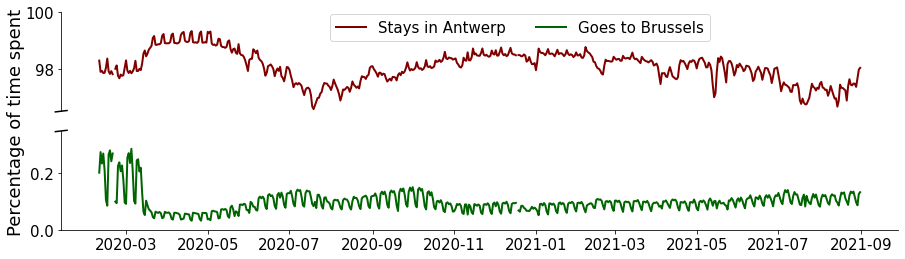

In [96]:
fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

axs[0].plot(dates, values, linewidth=2, label='Stays in Antwerp', color='maroon')
axs[1].plot(dates_bis, values_bis, linewidth=2, label='Goes to Brussels', color='darkgreen')

axs[0].set_ylim(96.5, 100)  # outliers only
axs[1].set_ylim(0, .35) 

# axs[0].legend()
axs[0].grid(False)
axs[1].grid(False)

axs[0].get_xaxis().set_visible(False)
axs[0].spines['bottom'].set_visible(False)

d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False, linewidth=1.5)
axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# Shared ylabel
fig.supylabel('Percentage of time spent', x=0.075)

# Shared legend
handles, labels = [(a + b) for a, b in zip(axs[0].get_legend_handles_labels(), axs[1].get_legend_handles_labels())]
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.55, 0.4, 0, 0.5))


## ... and problem arises from district data as well

In [2]:
date = '20210221'
data_location = "../../data/raw/mobility/proximus/arrondissements/"

# Load raw data
unprocessed_data_arr = load_datafile_proximus(date, data_location, agg='arr')

# Process data into pc-to-pc matrix
mmprox = load_mmprox(unprocessed_data_arr, values='est_staytime', agg='arr').drop(index=['-2'], columns=['ABROAD'])

# Fill in GDPR-protected -1 values with zeros (underestimates connection between postal codes)
mmprox = GDPR_staytime(mmprox, values = 0) # people times seconds times minutes times hours spent

# Aggregate at the level of provinces
mmprox = mm_aggregate(mmprox, agg='prov', from_agg='arr')

mmprox

district,10000,10000,10000,21000,20001,20001,20002,30000,30000,30000,...,70000,70000,80000,80000,80000,80000,80000,90000,90000,90000
mllp_district,,,,,,,,,,,,,,,,,,,,,
10000,2.072635e+10,8.362146e+09,1.045940e+10,6.351561e+07,1.437595e+08,2.194534e+08,1.127201e+07,2.672595e+08,2.861614e+06,1.096083e+07,...,6.836922e+07,3.675959e+07,7.350560e+05,2.263642e+07,4.853472e+07,1.856214e+07,3.647245e+06,3.321422e+07,8.313805e+06,6.453236e+06
20001,9.808160e+07,1.922613e+08,9.487088e+07,6.509442e+08,1.713323e+10,1.212373e+10,2.242207e+08,1.999949e+08,2.804711e+06,8.023263e+06,...,4.003957e+07,3.716629e+07,3.059116e+06,1.619748e+07,3.914101e+07,2.409172e+07,5.452821e+06,4.318338e+07,2.677794e+07,1.015284e+07
20002,7.283865e+06,3.280450e+06,2.451773e+06,2.087990e+08,1.554567e+08,6.120968e+07,1.322567e+10,7.694545e+07,4.793370e+05,1.302957e+06,...,2.412087e+06,2.060264e+06,8.270896e+06,1.424640e+07,2.426420e+07,2.872641e+07,1.150222e+07,4.995262e+07,1.389707e+08,1.632529e+07
21000,5.179738e+07,2.231681e+07,1.084815e+07,2.448834e+10,6.533295e+08,1.084663e+08,3.114018e+08,1.663356e+08,1.451474e+06,3.583632e+06,...,1.123132e+07,1.338748e+07,1.021532e+07,2.255603e+07,4.632277e+07,4.580523e+07,1.636766e+07,8.822656e+07,8.713636e+07,2.406335e+07
30000,4.966247e+07,1.525402e+07,1.616968e+07,4.541754e+07,3.758870e+07,2.967526e+07,8.601514e+06,6.978509e+09,1.100557e+09,2.689427e+09,...,7.498604e+06,7.046479e+06,0.000000e+00,1.206803e+07,3.938065e+07,1.156301e+07,0.000000e+00,2.692760e+07,5.522289e+06,3.847400e+06
40000,1.798021e+08,8.913692e+07,3.810468e+07,9.254737e+07,2.728206e+08,4.458861e+07,1.133693e+07,3.484594e+08,9.383625e+06,3.107410e+07,...,1.787106e+07,1.794069e+07,0.000000e+00,1.575382e+07,4.960438e+07,1.814268e+07,1.398330e+06,3.822661e+07,6.477789e+06,7.087179e+06
50000,7.481390e+06,2.111253e+06,0.000000e+00,1.546026e+08,7.907927e+07,7.716666e+06,2.021732e+08,6.070439e+07,7.573010e+05,3.571579e+07,...,0.000000e+00,8.143900e+05,3.856100e+06,1.473621e+07,2.424110e+07,3.058080e+07,1.032528e+07,6.011056e+07,1.582158e+08,1.257540e+08
60000,8.582219e+06,2.222993e+06,3.153454e+06,7.292252e+07,1.569300e+07,1.697072e+07,6.384450e+07,6.335942e+07,0.000000e+00,0.000000e+00,...,5.565320e+06,7.509483e+07,1.394253e+07,5.087469e+07,8.085026e+07,2.412495e+07,1.393612e+07,5.053537e+07,1.065602e+08,8.481635e+06
70000,4.013323e+07,1.408791e+07,1.106218e+08,1.772552e+07,1.861651e+07,1.555118e+08,4.127437e+06,7.160463e+07,4.905000e+05,1.171879e+06,...,5.389703e+09,4.958188e+09,6.981150e+05,7.013968e+06,1.357432e+07,3.373071e+06,0.000000e+00,6.827230e+06,4.151897e+06,1.028146e+06
